# Experiments on Dai's Framework

## Ask toloka: if we have a process and we detect workers quality, how to (without affecting their reputation):
1. Make good workers continue working, adding pages? expanding items in a page?
2. Make bad workers stop working, blank page? 

msg to telegram support group:
- you can make qualifying pool for all users and set a skill only for good workers. Then you can open pools only for that workers who have the skill. It shouldn't affect user reputation. Even if you stop worker by using ban on your project, it will not change user rating.
- When user accepts a task, he shoud be able to complete it. You can't close the task while performing.

## 1. Try POMDP models with different rewards
- Correct answer reward always = 0
- Vary Incorrect answer reward = {-10,...,-1000}
- Vary Create Job reward = {-1,...,-10}

### Results
Tried for wrong answer cost:
- -10, -500, -1000, -5000, -10000, -15000
- Loss Ratio = 5

### Base Results 23 states, $\gamma \sim Normal(1, 0.2)$ 
  ---
Results for cost: 10:
Cost mean: 1.0 - Std: 0.0
Recall mean: 0.747 - Std: 0.012
Precision mean: 0.758 - Std: 0.017
Loss mean: 0.749 - Std: 0.028

  ---  
Results for cost: 500:
Cost mean: 7.764 - Std: 0.309
Recall mean: 0.964 - Std: 0.012
Precision mean: 0.966 - Std: 0.009
Loss mean: 0.106 - Std: 0.033

  ---  
Results for cost: 1000:
Cost mean: 9.291 - Std: 0.374
Recall mean: 0.972 - Std: 0.011
Precision mean: 0.975 - Std: 0.008
Loss mean: 0.083 - Std: 0.03

  ---  
Results for cost: 5000:
Cost mean: 14.858 - Std: 0.324
Recall mean: 0.993 - Std: 0.005
Precision mean: 0.992 - Std: 0.005
Loss mean: 0.021 - Std: 0.013

  ---  
Results for cost: 10000:
Cost mean: 15.35 - Std: 0.313
Recall mean: 0.993 - Std: 0.002
Precision mean: 0.997 - Std: 0.003
Loss mean: 0.019 - Std: 0.006

  ---  
Results for cost: 15000:
Cost mean: 17.38 - Std: 0.412
Recall mean: 0.994 - Std: 0.003
Precision mean: 0.998 - Std: 0.002
Loss mean: 0.016 - Std: 0.006


## 2. Test with different number of states in the model of MDP
(difficulty, true_label)
- 5:  (0,0)(1,0)(0,1)(1,1)(T)
- 9:  (0,0)(0.33,0)(0.66,0)(1,0)(0,1)(0.33,1)(0.66,1)(1,1)(T)
- 13: (0,0)(0.2,0)(0.4,0)(0.6,0)(0.8,0)(1,0)(0,1)(0.2,1)(0.4,1)(0.6,1)(0.8,1)(1,1)(T)
- 17: (0,0)(0.15,0)(0.3,0)(0.45,0)(0.6,0)(0.75,0)(0.9,0)(1,0)(0,1)(0.15,1)(0.3,1)(0.45,1)(0.6,1)(0.75,1)(0.9,1)(1,1)(T)


### Results
  --- 
Num States: 5
Results for cost: 500:
Cost mean: 1.0 - Std: 0.0
Recall mean: 0.766 - Std: 0.013
Precision mean: 0.761 - Std: 0.015
Loss mean: 0.716 - Std: 0.039

  ---  
Num States: 9
Results for cost: 500:
Cost mean: 5.9 - Std: 0.063
Recall mean: 0.947 - Std: 0.007
Precision mean: 0.948 - Std: 0.007
Loss mean: 0.163 - Std: 0.022

  ---  
Num States: 13
Results for cost: 500:
Cost mean: 7.276 - Std: 0.104
Recall mean: 0.955 - Std: 0.011
Precision mean: 0.965 - Std: 0.007
Loss mean: 0.127 - Std: 0.029

  ---  
Num States: 17
Results for cost: 500:
Cost mean: 7.254 - Std: 0.123
Recall mean: 0.96 - Std: 0.009
Precision mean: 0.954 - Std: 0.012
Loss mean: 0.122 - Std: 0.028

  ---  

## 3. Try adding 1 the action of "leave item unclassified"

- POMDP defined: 23 states, 1 more action "leave unclassified"
    - T: $A_{unclassify}$ : $S_*$ : $S_{terminal}$ 1.000000
    - R: $A_{unclassify}$ : $s_i$ : $s_i$ : $S_*$ -250.000000
- Tried with unclassified action cost: 10, 50, 100, 250

### Results
---
- Unclassify with reward -250

    - Unclassified #: 0
    - Num States: 23
    - Cost Wrong Answer: -500
    - Cost mean: 7.88 - Std: 0.481
    - Recall mean: 0.955 - Std: 0.023
    - Precision mean: 0.956 - Std: 0.018
    - Loss mean: 0.135 - Std: 0.067
    - F-1: 0.956 - Std: 0.02
    - F-beta: 0.955 - Std: 0.022

---

### -> Never takes action "leave unclassified" independently of the cost

## 4. Try with different error rate distribution
- try to represent a set of workers composed by half very good and half very bad
- Good: $\gamma \sim Normal(1, 0.2)$ 
- Bad:  $\gamma \sim Normal(4, 0.5)$ 

In [9]:
from ModelLearning.utils import *


def get_acc(d, gamma):
    return 1/2 * (1 + (1-d)**gamma)

diffs = getDifficulties(0.1)
gammas = [1, 4]
for gamma in gammas:
    print(f"Worker Error Rate: {gamma}")
    for d in diffs:
        
        acc = get_acc(d, gamma)
        print(f"Difficulty: {d} - Accuracy: {acc}")

Worker Error Rate: 1
Difficulty: 0.0 - Accuracy: 1.0
Difficulty: 0.1 - Accuracy: 0.95
Difficulty: 0.2 - Accuracy: 0.9
Difficulty: 0.3 - Accuracy: 0.85
Difficulty: 0.4 - Accuracy: 0.8
Difficulty: 0.5 - Accuracy: 0.75
Difficulty: 0.6 - Accuracy: 0.7
Difficulty: 0.7 - Accuracy: 0.65
Difficulty: 0.8 - Accuracy: 0.6
Difficulty: 0.9 - Accuracy: 0.55
Difficulty: 1.0 - Accuracy: 0.5
Worker Error Rate: 4
Difficulty: 0.0 - Accuracy: 1.0
Difficulty: 0.1 - Accuracy: 0.82805
Difficulty: 0.2 - Accuracy: 0.7048000000000001
Difficulty: 0.3 - Accuracy: 0.62005
Difficulty: 0.4 - Accuracy: 0.5648
Difficulty: 0.5 - Accuracy: 0.53125
Difficulty: 0.6 - Accuracy: 0.5128
Difficulty: 0.7 - Accuracy: 0.50405
Difficulty: 0.8 - Accuracy: 0.5008
Difficulty: 0.9 - Accuracy: 0.50005
Difficulty: 1.0 - Accuracy: 0.5


### Results
  --- 
Num States: 23
Results for cost: 500:
Cost mean: 10.127 - Std: 0.202
Recall mean: 0.876 - Std: 0.027
Precision mean: 0.875 - Std: 0.018
Loss mean: 0.381 - Std: 0.067

  ---  

## 5. Try modelling workers error rate as a confusion matrix
- a worker error rate for possitive label class
- a worker error rate for negative label class

## 6. Dont update belief immediately using average error rate, first compute each worker error rate
- Using worker error rate with distribution Normal(1, 0.2)
- Change logic to the following procedure, for each item $i \in I$, and a set of workers $W$ :
    1. Request vote for an item i
    2. Collect a worker vote over item i
    3. Estimate worker error rate and item true label using EM
    4. Update belief state over item i


- Cost mean: 6.417 - Std: 0.371
- Recall mean: 0.974 - Std: 0.016
- Precision mean: 0.969 - Std: 0.026
- Loss mean: 0.081 - Std: 0.042
- F-1: 0.971 - Std: 0.015
- F-beta: 0.974 - Std: 0.015

## 7. Try with different dataset balances to have an insight about next items belief state
- think in if we see a big % of items classified in a class and a new item arrives, the prob distribution over states should not be equally likely between all states

# Charts

In [11]:
def get_metrics(lr, precision, recall):
    f1 = (2 * precision * recall) / (precision + recall)
    beta = lr
    f_beta = (beta**2 + 1) * precision * recall / (beta**2 * precision + recall)
    return f1, f_beta

In [28]:
results = {'s23-c10': {'cost': 1, 'cost_std': 0.0, 'recall': 0.747, 'recall_std': 0.012, 'precision': 0.758, 'precision_std':0.017, 'loss': 0.749, 'loss_std': 0.028},
          's23-c500': {'cost': 7.764, 'cost_std': 0.309, 'recall': 0.964, 'recall_std': 0.012, 'precision': 0.966, 'precision_std':0.009, 'loss': 0.106, 'loss_std': 0.033},
           's23-c1000': {'cost': 9.291, 'cost_std': 0.374, 'recall': 0.972, 'recall_std': 0.011, 'precision': 0.975, 'precision_std':0.008, 'loss': 0.083, 'loss_std': 0.003},
           's23-c5000': {'cost': 14.858, 'cost_std': 0.324, 'recall': 0.993, 'recall_std': 0.005, 'precision': 0.992, 'precision_std':0.005, 'loss': 0.021, 'loss_std': 0.028},
           's23-c10000': {'cost': 15.35, 'cost_std': 0.313, 'recall': 0.993, 'recall_std': 0.002, 'precision': 0.997, 'precision_std':0.003, 'loss': 0.019, 'loss_std': 0.006},
           's23-15000': {'cost': 17.38, 'cost_std': 0.412, 'recall': 0.994, 'recall_std': 0.003, 'precision': 0.998, 'precision_std':0.002, 'loss': 0.016, 'loss_std': 0.006},
           's5-c500': {'cost': 1, 'cost_std': 0, 'recall': 0.766, 'recall_std': 0.013, 'precision': 0.761, 'precision_std':0.015, 'loss': 0.716, 'loss_std': 0.039},
           's9-c500': {'cost': 15.9, 'cost_std': 0.063, 'recall': 0.947, 'recall_std': 0.007, 'precision': 0.948, 'precision_std':0.007, 'loss': 0.163, 'loss_std': 0.022},
           's13-c500': {'cost': 7.276, 'cost_std': 0.104, 'recall': 0.955, 'recall_std': 0.011, 'precision': 0.965, 'precision_std':0.007, 'loss': 0.127, 'loss_std': 0.029},
           's17-c500': {'cost': 7.254, 'cost_std': 0.123, 'recall': 0.96, 'recall_std': 0.009, 'precision': 0.954, 'precision_std':0.012, 'loss': 0.122, 'loss_std': 0.028},
           's23-c500-bimodal': {'cost': 10.127, 'cost_std': 0.202, 'recall': 0.876, 'recall_std': 0.027, 'precision': 0.875, 'precision_std':0.018, 'loss': 0.381, 'loss_std': 0.067}
          }
lr = 5
for name, values in results.items():
    f1, fbeta = get_metrics(lr, results[name]['precision'], results[name]['recall'])
    results[name]['f1'] = f1
    results[name]['f1_std'] = 0 
    results[name]['fbeta'] = fbeta
    results[name]['fbeta_std'] = 0
    
results['s23-c500-updating-n1'] = {'cost': 6.417, 'cost_std': 0.371, 'recall': 0.974, 'recall_std': 0.016, 'precision': 0.969, 'precision_std':0.026, 'loss': 0.081, 'loss_std': 0.042, 'f1':0.971, 'f1_std':0.015, 'fbeta':0.974, 'fbeta_std':0.015}
results['s23-c500-updating-n4'] = {'cost': 6.514, 'cost_std': 0.393,       'recall': 0.976, 'recall_std': 0.025,       'precision': 0.971, 'precision_std':0.025,       'loss': 0.075, 'loss_std': 0.063,       'f1':0.973, 'f1_std':0.018,       'fbeta':0.976, 'fbeta_std':0.024}

In [18]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
from IPython.display import HTML

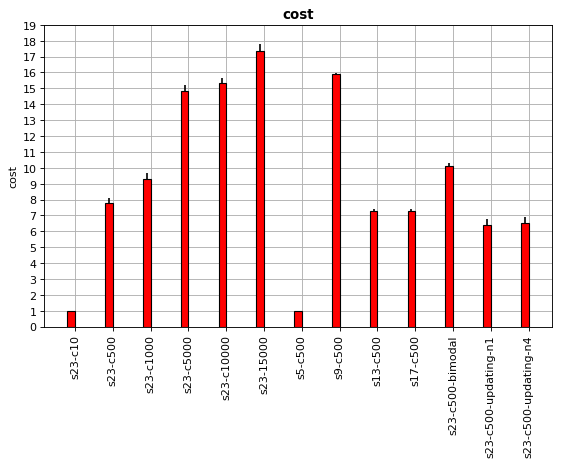

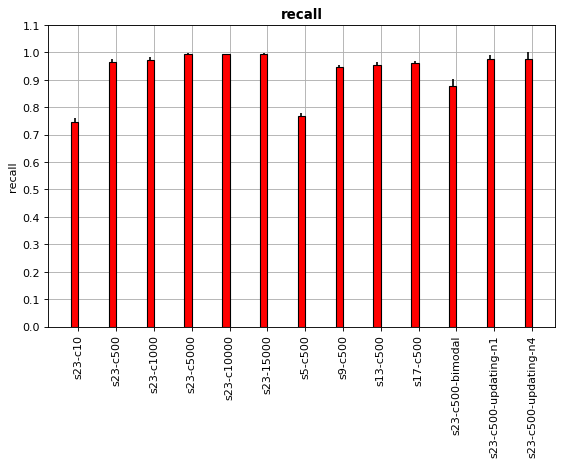

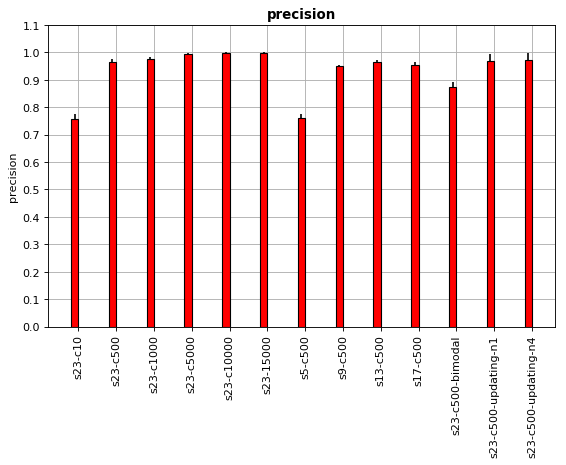

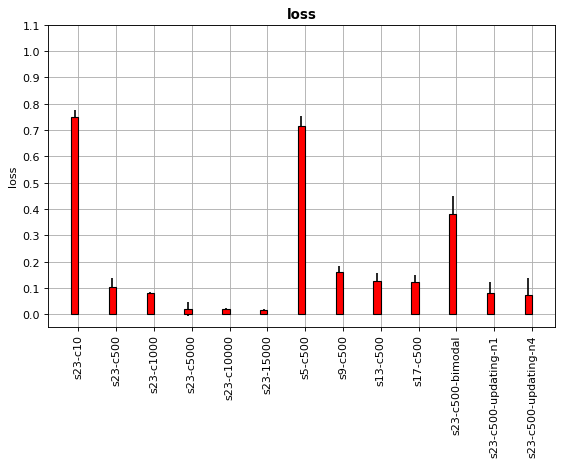

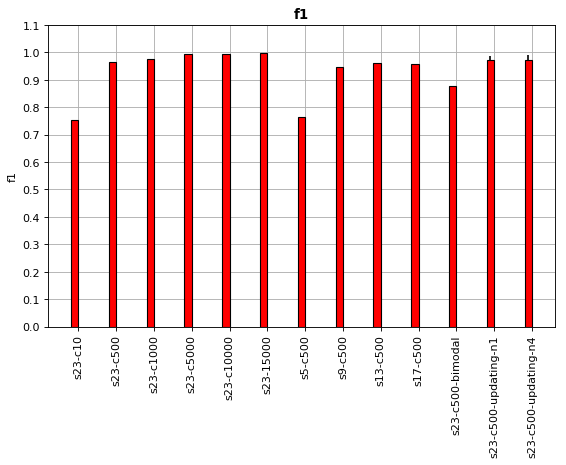

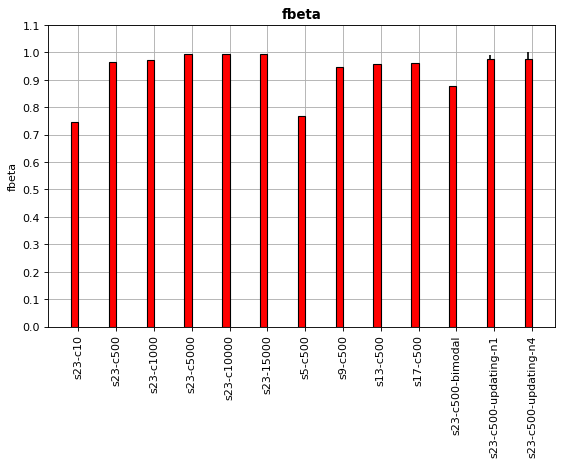

In [33]:
items = len(results)
ind = np.arange(items)
width = .2
xticks_ind = ind + width / 2
xticks_rotation = 90
xticks_names = [name for name, v in results.items()]

metrics = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

fig_num = 1

for metric in metrics:
    plt.figure(num=fig_num, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.subplots_adjust(bottom = .05)
    plt.subplot(221)
    metric_mean = [values[metric] for name, values in results.items()]
    metric_std = [values[f"{metric}_std"] for name, values in results.items()]

    p1 = plt.bar(ind, metric_mean, width, yerr=metric_std, zorder=3, color='red', edgecolor='black')
    plt.ylabel(metric)
    plt.title(metric, fontweight="bold")
    plt.xticks(xticks_ind, xticks_names, rotation=xticks_rotation)
    plt.grid(zorder=0)
    if max(metric_mean) < 1:
        plt.yticks(np.arange(0,1.2,.1))
    else:
        plt.yticks(np.arange(0,20,1))
    #plt.savefig("./charts/balanced_data_cost", bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    fig_num += 1
